# PHD

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
import matplotlib.animation as animation_lib # Changed import name to animation_lib
import matplotlib.patches as patches
from scipy.stats import multivariate_normal as mvn
from matplotlib.patches import Ellipse
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image as IPImage
from scipy.optimize import linear_sum_assignment

In [ ]:
def calculate_trajectory_bounds(x_targets, padding=30):
    """
    Calculate the boundaries for all target trajectories
    """
    all_x = np.concatenate([x[:, 0] for x in x_targets])
    all_y = np.concatenate([x[:, 1] for x in x_targets])

    x_min, x_max = np.min(all_x), np.max(all_x)
    y_min, y_max = np.min(all_y), np.max(all_y)

    return [x_min - padding, x_max + padding], [y_min - padding, y_max + padding]

def create_simulation(dt, q, r, targets_initial_states, steps=100):
    """
    Creates a simulation of multiple targets movement and measurements.

    Parameters:
    dt - time step
    q - process noise parameter
    r - measurement noise parameter
    targets_initial_states - list of initial states [x, y, vx, vy] for each target
    steps - number of simulation steps

    Returns:
    x_targets - actual states for all targets
    z_targets - measurements for all targets
    A, H, Q, R - model matrices
    """

    # Create model matrices
    A = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1,  0],
                  [0, 0, 0,  1]])

    Q = q**2 * np.array([[dt**3/3, 0      , dt**2/2, 0      ],
                        [0,       dt**3/3, 0,       dt**2/2],
                        [dt**2/2, 0,       dt,      0      ],
                        [0,       dt**2/2, 0,       dt     ]])

    H = np.array([[1., 0, 0, 0],
                  [0., 1, 0, 0]])

    R = r**2 * np.eye(2)

    num_targets = len(targets_initial_states)
    x_targets = []
    z_targets = []

    # Generate data for each target
    for target_idx in range(num_targets):
        x = np.zeros((steps, 4))
        x[0] = targets_initial_states[target_idx]
        z = np.zeros((steps, 2))
        z[0] = H @ x[0] + mvn.rvs(cov=R)

        for k in range(1, steps):
            x[k] = A @ x[k-1] + mvn.rvs(cov=Q)
            z[k] = H @ x[k] + mvn.rvs(cov=R)

        x_targets.append(x)
        z_targets.append(z)

    return x_targets, z_targets, A, H, Q, R

def generate_clutter(lambda_value, x_min, x_max, y_min, y_max, steps):
    """
    Generates clutter (false measurements) based on Poisson distribution.

    Parameters:
    lambda_value - average number of clutter measurements per scan
    x_min, x_max, y_min, y_max - boundaries of the observation area
    steps - number of time steps

    Returns:
    clutter - list of clutter measurements for each time step
    """
    clutter = []
    area = (x_max - x_min) * (y_max - y_min)

    for _ in range(steps):
        # Number of clutter points following Poisson distribution
        num_clutter = np.random.poisson(lambda_value)

        # Generate uniformly distributed clutter points
        clutter_points = np.zeros((num_clutter, 2))
        if num_clutter > 0:
            clutter_points[:, 0] = np.random.uniform(x_min, x_max, num_clutter)
            clutter_points[:, 1] = np.random.uniform(y_min, y_max, num_clutter)

        clutter.append(clutter_points)

    return clutter

def simulate_detection_failures(z_targets, detection_probability, failure_intervals=None):
    """
    Simulates measurement failures with manual intervals for each track.

    Parameters:
    z_targets - list of target measurements
    detection_probability - probability of random detection failures
    failure_intervals - list of (start, end) tuples for each target's failure window

    Returns:
    missing_indices - list of time indices with missing measurements for each target
    """
    missing_indices = []

    for target_idx, z_target in enumerate(z_targets):
        steps = len(z_target)
        target_missing = []

        # Add random failures based on detection probability
        for t in range(steps):
            if np.random.rand() > detection_probability:
                target_missing.append(t)

        # Add manual failure intervals if provided
        if failure_intervals and target_idx < len(failure_intervals):
            start, end = failure_intervals[target_idx]
            # Ensure the failure window is within bounds
            start = max(0, min(start, steps-1))
            end = max(0, min(end, steps))
            # Add all frames in the interval
            target_missing.extend(range(start, end))

        # Remove duplicates and sort
        target_missing = sorted(list(set(target_missing)))
        missing_indices.append(target_missing)

    return missing_indices

def combine_measurements(z_targets, clutter, missing_indices):
    """
    Combines target measurements and clutter, accounting for detection failures.

    Parameters:
    z_targets - list of target measurements
    clutter - list of clutter measurements
    missing_indices - list of time indices with missing measurements for each target

    Returns:
    combined_z - combined measurements for each time step
    missing_z_flat - flat list of time steps with missing measurements (by target)
    missing_z_by_target - dictionary mapping time step to list of targets with missing measurements
    """
    steps = len(clutter)
    combined_z = []
    missing_z_flat = []

    # New structure to track which targets have missing measurements at each time step
    missing_z_by_target = {t: [] for t in range(steps)}

    for t in range(steps):
        # Start with clutter
        time_measurements = clutter[t].copy() if len(clutter[t]) > 0 else np.empty((0, 2))

        # Add target measurements if not missing
        for target_idx, z_target in enumerate(z_targets):
            if t not in missing_indices[target_idx] and t < len(z_target):
                # Add this target's measurement
                if len(time_measurements) == 0:
                    time_measurements = z_target[t].reshape(1, 2)
                else:
                    time_measurements = np.vstack((time_measurements, z_target[t]))
            else:
                missing_z_flat.append(t)
                missing_z_by_target[t].append(target_idx)

        combined_z.append(time_measurements)

    return combined_z, list(set(missing_z_flat)), missing_z_by_target

In [ ]:
def predict_components(components, A, Q, P_S):
    """
    Predicts the state of all Gaussian components forward one time step

    Parameters:
    components - list of tuples (weight, mean, covariance)
    A - state transition matrix
    Q - process noise covariance
    P_S - probability of survival

    Returns:
    predicted_components - list of predicted components
    """
    predicted_components = []

    for weight, mean, cov in components:
        # Scale weight by probability of survival
        predicted_weight = P_S * weight

        # Update mean with state transition matrix
        predicted_mean = A @ mean

        # Update covariance
        predicted_cov = A @ cov @ A.T + Q

        # Add to list if weight is significant
        if predicted_weight > 1e-10:
            predicted_components.append((predicted_weight, predicted_mean, predicted_cov))

    return predicted_components

def add_birth_components(components, birth_components):
    """
    Add new birth components to existing components

    Parameters:
    components - list of tuples (weight, mean, covariance)
    birth_components - list of tuples (weight, mean, covariance) for new births

    Returns:
    new_components - combined list of components
    """
    return components + birth_components

def update_components(predicted_components, measurements, H, R, P_D, lambda_c, area):
    """
    Updates the PHD components based on the current measurements

    Parameters:
    predicted_components - list of tuples (weight, mean, covariance)
    measurements - array of measurements for the current time step
    H - measurement matrix
    R - measurement noise covariance
    P_D - probability of detection
    lambda_c - clutter rate
    area - surveillance area size

    Returns:
    updated_components - list of updated components
    """
    updated_components = []

    # Handle missed detections (scaling by (1-P_D))
    for weight, mean, cov in predicted_components:
        updated_components.append((weight * (1 - P_D), mean, cov))

    # No measurements case
    if len(measurements) == 0:
        return updated_components

    # Calculate clutter intensity
    clutter_intensity = lambda_c / area

    # Handle measurements
    for z in measurements:
        update_weights = []
        update_means = []
        update_covs = []
        likelihoods = []

        for j, (weight, mean, cov) in enumerate(predicted_components):
            # Kalman filter update
            S = H @ cov @ H.T + R  # Innovation covariance
            K = cov @ H.T @ np.linalg.inv(S)  # Kalman gain
            residual = z - H @ mean  # Measurement residual

            updated_mean = mean + K @ residual
            updated_cov = cov - K @ H @ cov

            # Calculate likelihood
            likelihood = mvn.pdf(z, mean=H @ mean, cov=S)

            # Updated weight
            updated_weight = P_D * weight * likelihood

            update_weights.append(updated_weight)
            update_means.append(updated_mean)
            update_covs.append(updated_cov)
            likelihoods.append(likelihood)

        # Calculate normalization factor
        eta = clutter_intensity + sum(P_D * weight * likelihood
                                   for weight, likelihood in zip([w for w, _, _ in predicted_components], likelihoods))

        # Add updated components with normalized weights
        for updated_weight, updated_mean, updated_cov in zip(update_weights, update_means, update_covs):
            if updated_weight > 1e-10:  # Only add significant components
                updated_components.append((updated_weight / eta, updated_mean, updated_cov))

    return updated_components

def prune_components(components, truncation_threshold, merge_threshold, max_components):
    """
    Prunes and merges Gaussian components to manage computational complexity

    Parameters:
    components - list of tuples (weight, mean, covariance)
    truncation_threshold - weight threshold for pruning
    merge_threshold - Mahalanobis distance threshold for merging
    max_components - maximum number of components to keep

    Returns:
    pruned_components - list of pruned and merged components
    """
    # Sort components by weight (descending)
    components = sorted(components, key=lambda x: x[0], reverse=True)

    # Truncate weak components
    pruned_components = [comp for comp in components if comp[0] > truncation_threshold]
    if not pruned_components:
        # Ensure we keep at least one component
        pruned_components = [components[0]] if components else []

    # Merge similar components
    merged_components = []
    while pruned_components:
        # Take the component with highest weight
        w_i, m_i, P_i = pruned_components[0]
        to_merge = [0]

        # Find all components to merge with this one
        for j in range(1, len(pruned_components)):
            w_j, m_j, P_j = pruned_components[j]

            # Calculate Mahalanobis distance
            inv_P_i = np.linalg.inv(P_i)
            diff = m_j - m_i
            distance = np.sqrt(diff.T @ inv_P_i @ diff)

            if distance < merge_threshold:
                to_merge.append(j)

        # If there are components to merge
        if len(to_merge) > 1:
            merged_weight = sum(pruned_components[j][0] for j in to_merge)

            # Weighted average for mean
            merged_mean = np.zeros_like(m_i)
            for j in to_merge:
                w_j, m_j, _ = pruned_components[j]
                merged_mean += (w_j / merged_weight) * m_j

            # Weighted average for covariance
            merged_cov = np.zeros_like(P_i)
            for j in to_merge:
                w_j, m_j, P_j = pruned_components[j]
                diff = m_j - merged_mean
                merged_cov += (w_j / merged_weight) * (P_j + np.outer(diff, diff))

            merged_components.append((merged_weight, merged_mean, merged_cov))
        else:
            merged_components.append((w_i, m_i, P_i))

        # Remove processed components
        pruned_components = [pruned_components[j] for j in range(len(pruned_components)) if j not in to_merge]

    # Cap the maximum number of components
    merged_components = sorted(merged_components, key=lambda x: x[0], reverse=True)
    merged_components = merged_components[:max_components]

    return merged_components

def extract_targets(components, extract_threshold):
    """
    Extracts target states from Gaussian components

    Parameters:
    components - list of tuples (weight, mean, covariance)
    extract_threshold - weight threshold for extracting a target state

    Returns:
    targets - list of extracted target states
    """
    targets = []
    for weight, mean, _ in components:
        if weight > extract_threshold:
            targets.append(mean)

    return targets

def gm_phd_filter(measurements, A, H, Q, R, birth_components, P_S, P_D, lambda_c, area,
                 truncation_threshold=1e-5, merge_threshold=4.0, extract_threshold=0.5, max_components=100):
    """
    Implements the Gaussian Mixture Probability Hypothesis Density filter

    Parameters:
    measurements - list of measurement arrays for each time step
    A - state transition matrix
    H - measurement matrix
    Q - process noise covariance
    R - measurement noise covariance
    birth_components - list of birth components (weight, mean, covariance)
    P_S - probability of survival
    P_D - probability of detection
    lambda_c - clutter rate
    area - surveillance area size
    truncation_threshold - weight threshold for pruning
    merge_threshold - distance threshold for merging
    extract_threshold - weight threshold for extracting a target state
    max_components - maximum number of components

    Returns:
    extracted_targets - list of extracted target states for each time step
    all_components - list of all components for each time step
    """
    # Initialize
    components = []
    extracted_targets = []
    all_components = []

    # Process each time step
    for k, z in enumerate(measurements):
        # Prediction step
        components = predict_components(components, A, Q, P_S)

        # Add birth components
        components = add_birth_components(components, birth_components)

        # Update step
        components = update_components(components, z, H, R, P_D, lambda_c, area)

        # Prune and merge components
        components = prune_components(components, truncation_threshold, merge_threshold, max_components)

        # Extract target states
        targets = extract_targets(components, extract_threshold)

        extracted_targets.append(targets)
        all_components.append(components)

    return extracted_targets, all_components

def generate_birth_components(targets_initial_states, birth_weight=0.03, birth_cov_value=10.0):
    """
    Generate birth components based on initial target states

    Parameters:
    targets_initial_states - list of initial target states
    birth_weight - weight for birth components
    birth_cov_value - covariance value for birth components

    Returns:
    birth_components - list of birth components (weight, mean, covariance)
    """
    birth_components = []
    state_dim = targets_initial_states[0].shape[0]

    for state in targets_initial_states:
        # Create birth mean (often with high uncertainty in velocity)
        birth_mean = state.copy()

        # Create birth covariance (high uncertainty)
        birth_cov = np.eye(state_dim) * birth_cov_value

        birth_components.append((birth_weight, birth_mean, birth_cov))

    return birth_components




In [ ]:
def confidence_ellipse(loc, cov, ax, n_std=2.0, track_color="green", **kwargs):

    # Захист від сингулярних матриць
    cov = cov + np.eye(2) * 1e-6

    if np.linalg.det(cov) < 1e-10:
        return None

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)

    eigenvals, eigenvecs = np.linalg.eigh(cov)
    order = eigenvals.argsort()[::-1]
    eigenvals = eigenvals[order]
    eigenvecs = eigenvecs[:, order]

    angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))

    width, height = 2 * n_std * np.sqrt(eigenvals)

    ellipse = Ellipse(xy=loc, width=width, height=height, angle=angle, facecolor=track_color, **kwargs)

    ax.add_patch(ellipse)
    return ellipse

def animate_phd_filter(measurements, clutter, x_targets, extracted_targets, all_components,
                       missing_z_by_target=None, filename="phd_tracking.gif",
                       title="Gaussian Mixture PHD Filter Tracking", fps=5,
                       x_bounds=None, y_bounds=None):
    """
    Створює анімацію роботи GM-PHD фільтра.

    Parameters:
    measurements - комбіновані вимірювання (список масивів)
    clutter - вимірювання клатеру (список масивів)
    x_targets - реальні траєкторії цілей
    extracted_targets - оцінені цілі (результат PHD фільтра)
    all_components - всі компоненти PHD фільтра для кожного кроку
    missing_z_by_target - словник з пропущеними вимірюваннями
    filename - ім'я вихідного GIF файлу
    title - заголовок анімації
    fps - кадрів за секунду
    x_bounds - межі по х (x_min, x_max)
    y_bounds - межі по у (y_min, y_max)

    Returns:
    IPython Image об'єкт з анімацією
    """
    # Створюємо різні кольори для справжніх траєкторій
    num_targets = len(x_targets)
    target_colors = plt.cm.tab10(np.linspace(0, 1, num_targets))

    # Створюємо список кольорів для оцінених траєкторій
    track_colors = [
        '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
        '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
        '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5'
    ]

    # Обробка пустого словника missing_z_by_target
    if missing_z_by_target is None:
        missing_z_by_target = {}

    # Створюємо фігуру
    fig, ax = plt.subplots(figsize=(12, 8))

    # Встановлюємо межі
    if x_bounds is None or y_bounds is None:
        # Збираємо всі точки для визначення меж
        all_points = []

        # Додаємо вимірювання
        for z in measurements:
            if len(z) > 0:
                all_points.append(z)

        # Додаємо справжні траєкторії
        for x in x_targets:
            all_points.append(x[:, :2])

        # Додаємо клатер
        for c in clutter:
            if len(c) > 0:
                all_points.append(c)

        # Об'єднуємо всі точки
        all_points = np.vstack([p for p in all_points if len(p) > 0])
        margin = 30
        x_min, x_max = np.min(all_points[:, 0]) - margin, np.max(all_points[:, 0]) + margin
        y_min, y_max = np.min(all_points[:, 1]) - margin, np.max(all_points[:, 1]) + margin

        # Забезпечуємо квадратне співвідношення сторін
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        max_range = max(x_max - x_min, y_max - y_min) / 2
        x_min, x_max = x_center - max_range, x_center + max_range
        y_min, y_max = y_center - max_range, y_center + max_range
    else:
        x_min, x_max = x_bounds
        y_min, y_max = y_bounds

    # Створюємо словник для відстеження траєкторій оцінених цілей
    track_histories = {}

    def update(frame):
        ax.clear()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_title(f"{title} - Frame {frame}")
        ax.grid(True, alpha=0.3)

        # Малюємо реальні траєкторії різними кольорами
        for i, x_target in enumerate(x_targets):
            # Малюємо повну траєкторію пунктирною лінією
            ax.plot(x_target[:, 0], x_target[:, 1], '--',
                   color=target_colors[i], linewidth=1.5,
                   alpha=0.6, label=f'True trajectory {i+1}')


        # Малюємо поточний клатер
        if frame < len(clutter) and len(clutter[frame]) > 0:
            ax.plot(clutter[frame][:, 0], clutter[frame][:, 1], 'kx',
                   markersize=6, alpha=0.5, label='Clutter')

        # Малюємо поточні вимірювання та позначаємо відсутні вимірювання
        if frame < len(measurements):
            current_z = measurements[frame]

            # Отримуємо цілі з пропущеними вимірюваннями для цього кадру
            missing_targets = missing_z_by_target.get(frame, [])

            # Розділяємо дійсні та відсутні вимірювання
            valid_measurements = []
            missing_positions = []

            for target_idx in range(len(x_targets)):
                if frame >= len(x_targets[target_idx]):
                    continue

                # Отримуємо реальну позицію для цієї цілі на поточному кадрі
                true_pos = x_targets[target_idx][frame, :2]

                if target_idx in missing_targets:
                    # Це пропущене вимірювання - зберігаємо для сірого кола
                    missing_positions.append(true_pos)
                else:
                    # Це дійсне вимірювання - шукаємо відповідне вимірювання в current_z
                    for meas in current_z:
                        if np.linalg.norm(meas[:2] - true_pos) < 10:  # Простий поріг відстані
                            valid_measurements.append(meas)
                            break

            # Малюємо дійсні вимірювання (сині кола)
            if len(valid_measurements) > 0:
                valid_measurements = np.array(valid_measurements)
                ax.plot(valid_measurements[:, 0], valid_measurements[:, 1], 'bo',
                       markersize=8, alpha=0.7, label='Measurement')

            # Малюємо пропущені вимірювання (сірі кола)
            if len(missing_positions) > 0:
                missing_positions = np.array(missing_positions)
                ax.plot(missing_positions[:, 0], missing_positions[:, 1], 'o',
                       color='gray', markersize=8, mfc='none', alpha=0.8,
                       label='Missing measurement')

        # Обробляємо компоненти PHD фільтра
        if frame < len(all_components):
            components = all_components[frame]

            # Малюємо всі компоненти з вагою вище порогу
            for weight, mean, cov in components:
                if weight > 0.1:  # тільки значущі компоненти
                    loc = (mean[0], mean[1])
                    # Малюємо довірчий еліпс для компоненти
                    confidence_ellipse(
                        loc=loc,
                        cov=cov[:2, :2],
                        ax=ax,
                        n_std=3.0,
                        track_color='lightgray',
                        alpha=0.2,
                        linewidth=1
                    )

        # Обробляємо оцінені цілі
        if frame < len(extracted_targets):
            current_targets = extracted_targets[frame]

            # Оновлюємо історію траєкторій
            for i, target in enumerate(current_targets):
                # Використовуємо простий алгоритм асоціації для відстеження траєкторій
                best_track_id = None
                min_dist = float('inf')

                # Знаходимо найближчий трек для цієї цілі
                for track_id, history in track_histories.items():
                    if len(history) > 0:
                        last_pos = history[-1][:2]
                        dist = np.linalg.norm(target[:2] - last_pos)
                        if dist < min_dist and dist < 20:  # поріг для асоціації
                            min_dist = dist
                            best_track_id = track_id

                if best_track_id is not None:
                    # Додаємо до існуючого треку
                    track_histories[best_track_id].append(target)
                else:
                    # Створюємо новий трек
                    new_id = len(track_histories)
                    track_histories[new_id] = [target]

            # Малюємо траєкторії
            for track_id, history in track_histories.items():
                color = track_colors[track_id % len(track_colors)]

                # Перевіряємо, чи трек активний у поточному кадрі
                is_active = False
                for target in current_targets:
                    for hist_point in history[-3:]:  # Перевіряємо останні 3 позиції
                        if np.linalg.norm(target[:2] - hist_point[:2]) < 5:
                            is_active = True
                            break
                    if is_active:
                        break

                # Малюємо історію траєкторії до поточного кадру
                if len(history) > 1:
                    track_pts = np.array(history)
                    ax.plot(track_pts[:, 0], track_pts[:, 1], '-',
                           color=color, alpha=0.8, linewidth=2,
                           label=f'Track {track_id}' if is_active else "")

                # Малюємо поточну позицію з міткою треку
                if is_active and len(history) > 0:
                    current_pos = history[-1][:2]
                    ax.plot(current_pos[0], current_pos[1], 'o',
                           color=color, markersize=8)

                    # Додаємо мітку треку
                    ax.annotate(f'Track {track_id}',
                               xy=current_pos, xytext=(10, 0),
                               textcoords='offset points',
                               color=color, fontsize=9,
                               bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))

                    # Малюємо довірчий еліпс для активних треків
                    for target in current_targets:
                        if np.linalg.norm(target[:2] - current_pos) < 5:
                            # Знаходимо відповідну компоненту
                            for weight, mean, cov in all_components[frame]:
                                if np.linalg.norm(mean[:2] - target[:2]) < 5:
                                    confidence_ellipse(
                                        loc=current_pos,
                                        cov=cov[:2, :2],
                                        ax=ax,
                                        n_std=2.0,
                                        track_color=color,
                                        alpha=0.3,
                                        linewidth=1
                                    )
                                    break

        # Додаємо інформаційну панель
        info_text = (
            f"Time: {frame}\n"
            f"Active tracks: {len(extracted_targets[frame]) if frame < len(extracted_targets) else 0}\n"
        )

        if frame in missing_z_by_target and missing_z_by_target[frame]:
            info_text += f"MISSING MEASUREMENTS!"

        ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Оптимізуємо легенду - показуємо тільки унікальні записи
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(),
                 loc='upper right', fontsize=8, framealpha=0.8)

        return ax

    # Створюємо анімацію
    steps = min(len(measurements), max([len(x) for x in x_targets]))
    ani = animation_lib.FuncAnimation( # Use animation_lib instead of animation
        fig, update, frames=steps,
        interval=1000/fps, blit=False
    )

    # Зберігаємо як GIF
    ani.save(filename, writer='pillow', fps=fps, dpi=100)
    plt.close(fig)

    return IPImage(filename=filename)



In [ ]:
def separate_measurements_and_clutter(z_targets, clutter, missing_indices):
    """
    Separates real measurements from clutter for visualization purposes

    Parameters:
    z_targets - list of lists of true target measurements
    clutter - list of clutter measurements for each time step
    missing_indices - list of indices where measurements are missing

    Returns:
    real_measurements - list of real target measurements for each time step
    clutter_only - list of clutter measurements for each time step
    """
    steps = len(clutter)
    real_measurements = [[] for _ in range(steps)]
    clutter_only = [c.copy() for c in clutter]  # Start with all clutter

    # For each target, add its measurements to the real measurements list
    for target_idx, target_z in enumerate(z_targets):
        for t, z in enumerate(target_z):
            # Check if this measurement is not missing
            if (target_idx, t) not in missing_indices:
                real_measurements[t].append(z)

    return real_measurements, clutter_only

In [ ]:
def calculate_ospa_metric(true_tracks, estimated_tracks, c=100, p=1):
    """
    Calculate OSPA (Optimal Sub-Pattern Assignment) metric between true and estimated tracks

    Parameters:
    true_tracks - list of true target states
    estimated_tracks - list of estimated target states
    c - cut-off parameter
    p - order parameter

    Returns:
    ospa - OSPA distance
    """
    if not true_tracks or not estimated_tracks:
        return c if true_tracks or estimated_tracks else 0

    m = len(true_tracks)
    n = len(estimated_tracks)

    # Calculate pairwise distances
    distances = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            # Use only position for distance calculation
            d = np.linalg.norm(true_tracks[i][:2] - estimated_tracks[j][:2])
            distances[i, j] = min(d, c) ** p

    # Solve assignment problem
    row_ind, col_ind = linear_sum_assignment(distances)

    # Calculate OSPA
    ospa_dist = 0
    if m <= n:
        ospa_dist = (sum(distances[row_ind, col_ind]) + (n - m) * (c ** p)) / n
    else:
        ospa_dist = (sum(distances[row_ind, col_ind]) + (m - n) * (c ** p)) / m

    return ospa_dist ** (1/p)


def calculate_cardinality(extracted_targets, x_targets, steps):
    """
    Calculate the cardinality (number of targets) estimated vs true over time

    Parameters:
    extracted_targets - list of extracted target states for each time step
    x_targets - list of true target states for each target
    steps - number of time steps

    Returns:
    true_cardinality - true number of targets at each time step
    estimated_cardinality - estimated number of targets at each time step
    """
    true_cardinality = np.zeros(steps)
    estimated_cardinality = np.zeros(steps)

    # Count true targets
    for t in range(steps):
        count = 0
        for target in x_targets:
            if t < len(target):
                count += 1
        true_cardinality[t] = count

    # Count estimated targets
    for t in range(len(extracted_targets)):
        estimated_cardinality[t] = len(extracted_targets[t])

    return true_cardinality, estimated_cardinality

def plot_cardinality(true_cardinality, estimated_cardinality):
    """
    Plot the cardinality over time

    Parameters:
    true_cardinality - true number of targets at each time step
    estimated_cardinality - estimated number of targets at each time step
    """
    plt.figure(figsize=(12, 6))
    plt.plot(true_cardinality, 'b-', linewidth=2, label='True Cardinality')
    plt.plot(estimated_cardinality, 'r--', linewidth=2, label='Estimated Cardinality')
    plt.xlabel('Time Step')
    plt.ylabel('Number of Targets')
    plt.title('Cardinality Estimation')
    plt.legend()
    plt.grid(True)
    plt.show()

def calculate_ospa_over_time(x_targets, extracted_targets, steps):
    """
    Calculate OSPA metric over time

    Parameters:
    x_targets - list of true target states for each target
    extracted_targets - list of extracted target states for each time step
    steps - number of time steps

    Returns:
    ospa_values - OSPA values for each time step
    """
    ospa_values = np.zeros(steps)

    for t in range(min(steps, len(extracted_targets))):
        # Collect true target states at this time
        true_states = []
        for target in x_targets:
            if t < len(target):
                true_states.append(target[t])

        # Calculate OSPA
        if extracted_targets[t]:
            ospa_values[t] = calculate_ospa_metric(true_states, extracted_targets[t])
        elif true_states:  # No estimated targets but true targets exist
            ospa_values[t] = 100  # Maximum error (c parameter)

    return ospa_values

def plot_ospa(ospa_values):
    """
    Plot the OSPA metric over time

    Parameters:
    ospa_values - OSPA values for each time step
    """
    plt.figure(figsize=(12, 6))
    plt.plot(ospa_values, 'b-', linewidth=2)
    plt.xlabel('Time Step')
    plt.ylabel('OSPA Distance')
    plt.title('OSPA Metric Over Time')
    plt.grid(True)
    plt.show()


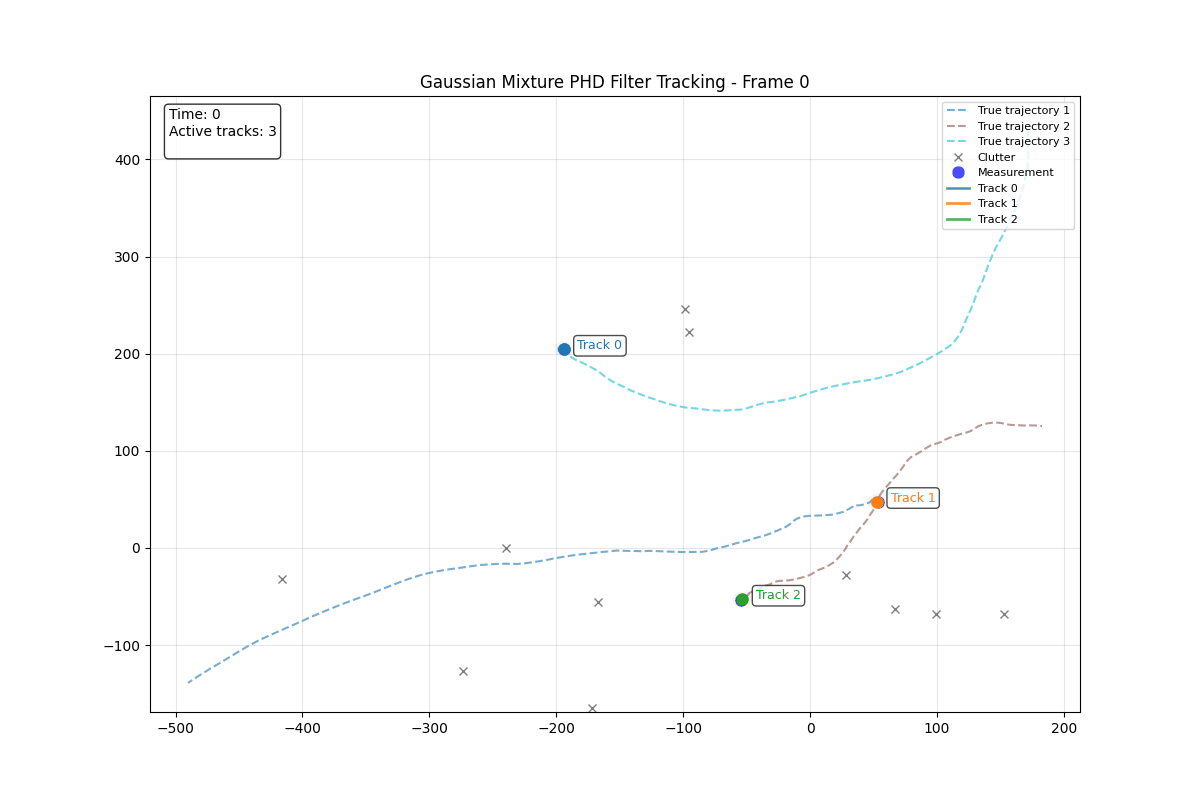

In [ ]:
dt = 1.0
q = 0.5
r = 3.0
steps = 100
lambda_value = 10
Pd = 0.94
gamma = 9.0
P_D = 0.96
P_S = 0.96
r_0 = 0.3
confirm_threshold = 0.9
delete_threshold = 0.3
init_threshold = 20
merge_threshold = 2.0

# Target initial states
targets_initial_states = [
    np.array([50., 50., -1., -1.]),     # Ціль 1
    np.array([-50., -50., 1., 1.]),     # Ціль 2
    np.array([-196., 204., 4., -4.])    # Ціль 7
]

# Create simulation
x_targets, z_targets, A, H, Q, R = create_simulation(
    dt=dt, q=q, r=r,
    targets_initial_states=targets_initial_states,
    steps=steps
)

x_bounds, y_bounds = calculate_trajectory_bounds(x_targets, padding=30)

# Generate clutter
clutter = generate_clutter(
    lambda_value=lambda_value,
    x_min=x_bounds[0], x_max=x_bounds[1],
    y_min=y_bounds[0], y_max=y_bounds[1],
    steps=steps
)

# Simulate detection failures and combine measurements
missing_indices = simulate_detection_failures(z_targets, detection_probability=Pd, failure_intervals=[(10, 12), (30, 33), (60, 64)])
combined_z, _, missing_z_by_target = combine_measurements(z_targets, clutter, missing_indices)

# Calculate surveillance area
area = (x_bounds[1] - x_bounds[0]) * (y_bounds[1] - y_bounds[0])

birth_components = generate_birth_components(targets_initial_states, birth_weight=0.03, birth_cov_value=25.0)
extracted_targets, all_components = gm_phd_filter(
    measurements=combined_z,
    A=A, H=H, Q=Q, R=R,
    birth_components=birth_components,
    P_S=P_S, P_D=P_D, lambda_c=lambda_value, area=area,
    truncation_threshold=1e-5,
    merge_threshold=merge_threshold,
    extract_threshold=0.5,
    max_components=100
)

# Приклад використання:
animation = animate_phd_filter(measurements=combined_z, clutter=clutter, x_targets=x_targets, extracted_targets=extracted_targets, all_components=all_components,
                       missing_z_by_target=missing_z_by_target, filename="phd_tracking.gif",
                       title="Gaussian Mixture PHD Filter Tracking", fps=5,
                       x_bounds=x_bounds, y_bounds=y_bounds)

# Відображення анімації в Colab
animation


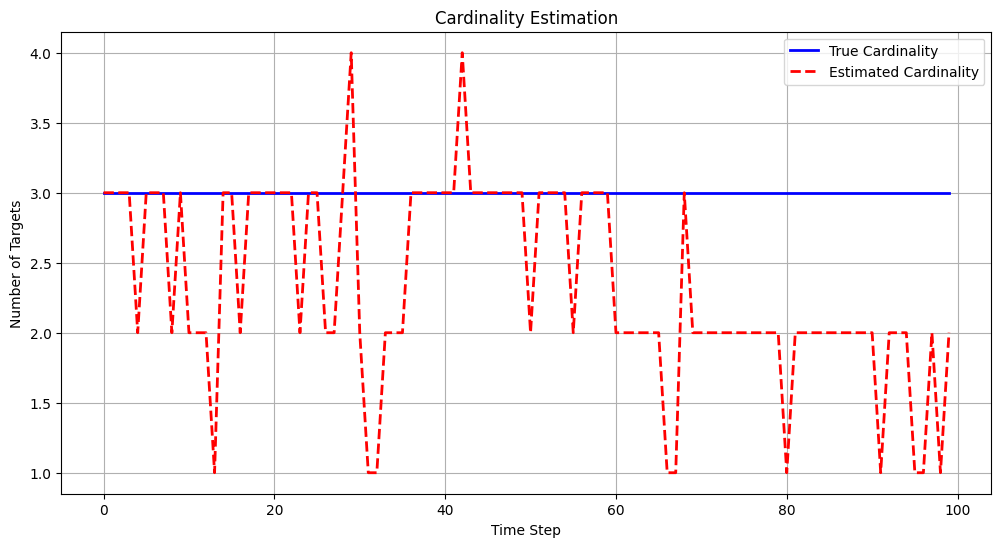

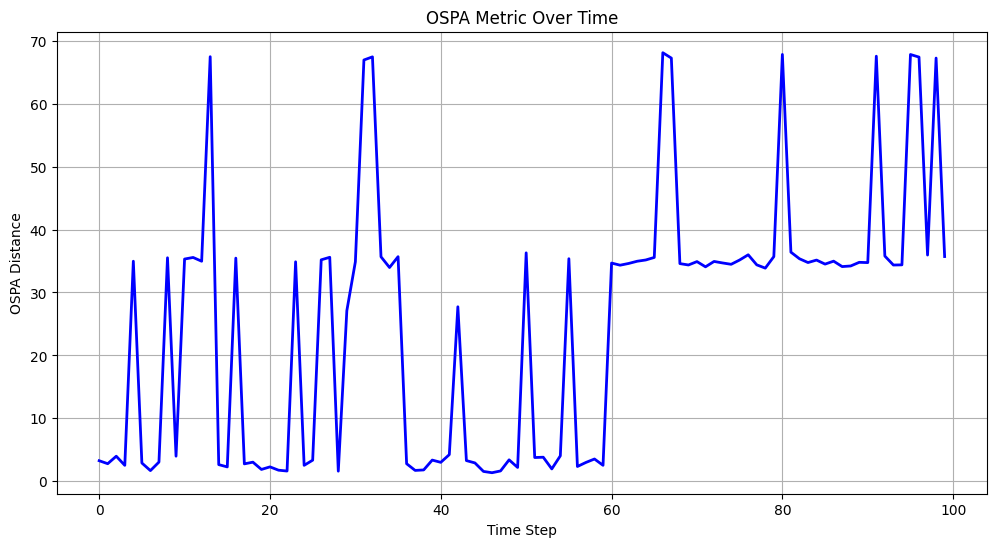

In [ ]:
# Calculate and plot cardinality
true_cardinality, estimated_cardinality = calculate_cardinality(extracted_targets, x_targets, steps)
plot_cardinality(true_cardinality, estimated_cardinality)

# Calculate and plot OSPA metric
ospa_values = calculate_ospa_over_time(x_targets, extracted_targets, steps)
plot_ospa(ospa_values)